## Super-simplified neural odes

dmevdok@gmail.com

Text(0.5, 1.0, 'the data')

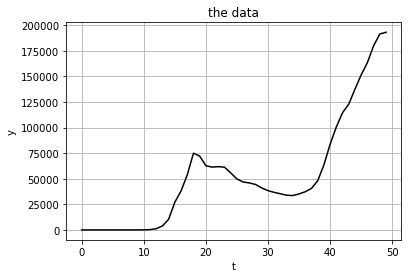

In [668]:
import pandas as pd
import numpy as np

# covid data

df = pd.read_csv('data.csv')
data = np.flip(df[df.countriesAndTerritories == 'Russia'].cases_weekly.values)[:-1]
true = torch.tensor(data.copy(), dtype=torch.float)
plt.plot(data, color='black')
plt.grid(True)
plt.xlabel('t')
plt.ylabel('y')
plt.title('the data')

In [669]:
import matplotlib.pyplot as plt
import torch
import math

LEARNING_RATE = 0.01

# some numeric method of solving ODEs
def ode_solve(z0, t0, t1, f):
    h_max = 0.2
    n_steps = math.ceil((abs(t1 - t0)/h_max))
    h = (t1 - t0)/n_steps
    t = t0
    z = z0
    for i_step in range(n_steps):
        z = z + h * f(t, z)
        t = t + h
    return z

# a model we wrap into it
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__() 
        self.l1 = torch.nn.Linear(1,100)
        self.l2 = torch.nn.Sigmoid()
        self.l3 = torch.nn.Linear(100,1)
        
    def forward(self,t,y):
        y = self.l1(y*t)
        y = self.l2(y)
        y = self.l3(y*t)
        return y
    
    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

In [670]:
# adjoint dynamics

def adjoint(t0, t1, yt1, a):
    s0 = torch.zeros(torch.nn.utils.parameters_to_vector(model.parameters()).shape[0])
    def aug_dynamics(s, t):
        adfdp = torch.autograd.grad(yt1, model.parameters(), grad_outputs=(a.T), allow_unused=True, retain_graph=True)
        return -torch.nn.utils.parameters_to_vector(adfdp)
    return ode_solve(s0, t1, t0, aug_dynamics)

In [682]:
# reset the model

model = Model()
criterion = torch.nn.MSELoss()
my_epoch_counter = 0

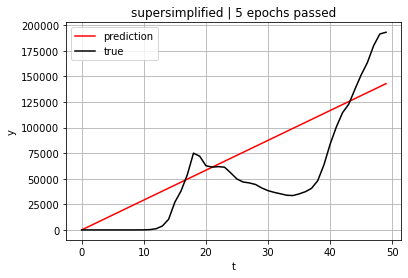

In [687]:
# perform one epoch

my_epoch_counter += 1

prediction = torch.zeros(len(data))
prediction[0] = data[0]
yt = torch.tensor([data[0]], dtype=torch.float)
saved_tensors = [yt]

t0, t1 = 0, 1

# go forward in time, solving original ODE
while t1 < len(data):
    yt = ode_solve(yt, t0, t1, model)
    prediction[t1] = yt
    saved_tensors.append(yt)
    t0, t1 = t0+1, t1+1

loss = criterion(prediction, true)

# go backwards in time, solving adjoint dynamics
while t1 > 1:
    dldtheta = adjoint(t0, t1, saved_tensors[t1-1], torch.autograd.grad(loss, yt, retain_graph=True)[0])
    parameters = torch.nn.utils.parameters_to_vector(model.parameters())
    parameters = parameters - LEARNING_RATE * dldtheta
    t0, t1 = t0-1, t1-1
torch.nn.utils.vector_to_parameters(parameters, model.parameters())

plt.plot(prediction.detach().numpy(), color='red', label="prediction")
plt.plot(data, color='black', label="true")
plt.grid(True)
plt.legend()
plt.xlabel('t')
plt.ylabel('y')
plt.title(f'supersimplified | {my_epoch_counter} epochs passed')
None

## Comparison with torchdiffeq


In [702]:
from torchdiffeq import odeint_adjoint as odeint

DEVICE = "cpu:0"

In [765]:
# reset the model

model = Model()
func = model.to(DEVICE)

batch_y = torch.tensor([data], dtype=torch.float)
batch_y0 = torch.tensor([data[0]], dtype=torch.float)
batch_t = torch.tensor([i for i in range(len(data))], dtype=torch.float)

optimizer = torch.optim.SGD(func.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.L1Loss()

epoch_counter = 0

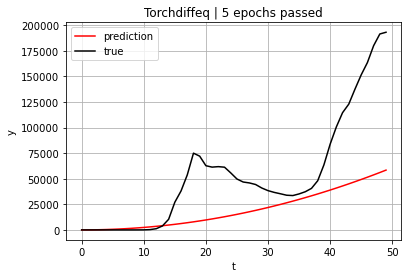

In [770]:
# perform one epoch

epoch_counter += 1

optimizer.zero_grad()
pred_y = odeint(func, batch_y0, batch_t).to(DEVICE)
loss = criterion(pred_y, batch_y.T)
loss.backward()
optimizer.step()

plt.plot(pred_y.detach().numpy(), color='red', label="prediction")
plt.plot(data, color='black', label="true")
plt.grid(True)
plt.legend()
plt.xlabel('t')
plt.ylabel('y')
plt.title(f'Torchdiffeq | {epoch_counter} epochs passed')
None